In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# allows for priting big dataframes
pd.options.display.max_rows = None 
pd.options.display.max_columns = None

# NA's dataframe Creator
This function creates 2 dataframes: the first contains the total number of na values by each country and feature, and the second contains the na proportion for that country and feature


In [2]:
def na_dfs(data):
    '''
    Returns total number of nas per feature and feature percentage of nas, for each country
    '''

    # saves nas count, as well as percentage of nas for each feature, correpoding to each country
    total_nas_df = data.isna().groupby('location').sum() # total number of nas per feature
    nas_perc = total_nas_df.div(data.groupby('location').size(), axis='rows')  * 100   # feature percentage     of nas, for each country

    return total_nas_df, nas_perc


# Initial Processing
Loads dataframe;

Set "location" and "date" as indexes (making it a multindex dataframe);

Drops unwanted countries (criteria explined bellow);

Drops unwanted features (criteria explined bellow);

Sets gpd per capita for Cuba.

In [3]:
# load dataframes
data = pd.read_csv('owid_covid_data_June-14-2020.csv')

# converts date from string to pandas datetimeindex format
data.date = pd.DatetimeIndex(data.date)

# transforms dataframe into a multindex (location and date) dataframe
index = pd.MultiIndex.from_frame(data[['location', 'date']])
data.set_index(index, inplace=True)
data.sort_index(inplace=True)
data.drop(columns=['location', 'date'], inplace=True)

# update na's dataframes
total_nas_df, nas_perc = na_dfs(data)

# drops unwanted countries
countries_to_drop = ['International','Hong Kong'] # removed for lack of data
countries_to_drop.extend(['Curacao', 'French Polynesia', 'Guam', 'New Caledonia', 'Somalia', 'United States Virgin Islands']) # removed for lack of gdp per capita data
countries_to_drop.extend(nas_perc[nas_perc['population_density'] != 0].index.values) # countries with missing values for population density are eliminated
countries_to_drop.extend(nas_perc[(nas_perc['median_age'] != 0) | (nas_perc['aged_65_older'] != 0)].index.values) # countries with missing values for median age or aged 65 older are eliminated
countries_to_drop.extend(['Aruba']) # removed for lack of cvd death rate data
countries_to_drop.extend(nas_perc[nas_perc['stringency_index'] == 100].index.values) # removed countries that have no recorded stringency index (those with only some missing values will be completed with already available data)
data.drop(countries_to_drop, inplace=True)

# drops unwanted features
columns_to_drop = ['total_tests', 'new_tests', 'new_tests_smoothed', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'tests_units'] # tests columns removed for lack of data
columns_to_drop.extend(['continent'])   # not necessary
columns_to_drop.extend(['aged_70_older']) # removed for duplicity of data (there is already a aged 65 older column)
data.drop(columns=columns_to_drop, inplace=True)

data.loc['Cuba']['gdp_per_capita'] = 20611.0 # data obtained from https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_PIB_(Paridade_do_Poder_de_Compra)_per_capita (it was very hard to find data from Cuba that was recent. The most recent data was an estimate by the CIA, but we can safely assume that this data would be biased)


# Completes Date Range
Creates new entries for missing dates (each country will have the same date range);

Complete missing values (create by the making of new entries explained above) for constant variables (same value for all dates, varing with country)

In [4]:
# fill in missing dates, using the range between the earliest and latest recorded samples
start_date = data.index.get_level_values('date').min()
end_date = data.index.get_level_values('date').max()
date_range = pd.date_range(start_date, end_date)
date_range = pd.Index(date_range, name='date')
countries = data.groupby('location').max().index
new_index = pd.MultiIndex.from_product([countries, date_range])
data = data.reindex(new_index)

columns_to_prop = ['iso_code',    # data is constant for each country, so first fill Na's with forward pad for Na's that are on tail, then with backward pad for Na's that are on start of each country
                    'population',
                    'population_density',
                    'median_age',      
                    'aged_65_older',
                    'gdp_per_capita',
                    'cvd_death_rate',
                    'diabetes_prevalence']
data[columns_to_prop] = data[columns_to_prop].groupby('location').fillna(method='backfill') # backward propagation
data[columns_to_prop] = data[columns_to_prop].groupby('location').fillna(method='ffill')    # forward propagation

# Negative Values in Data
For some reason, there are some negative values in the dataframe. Shows them and replace with Na's, so they can be replaced later with all other Na values.

In [5]:
# show features that have negative (invalid) values
df = data.select_dtypes(np.number)[data.select_dtypes(np.number) < 0].groupby('location').count()
df[df.sum(axis=1) > 0]

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
location,,,,,,,,,,,,,,,,,,,,,
Benin,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ecuador,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
France,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lithuania,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Panama,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Portugal,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Spain,0,2,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Uganda,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
United Kingdom,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# replaces all negative values found in columns with Na's (so they can be replaced using the chosen method for missing data points later on)
change_columns = ['new_cases', 'new_deaths', 'new_cases_per_million', 'new_deaths_per_million']    # columns to be processed (update columns)
data[change_columns] = data[change_columns].where(cond=~(data[change_columns] < 0), other=np.nan)


# Tracking Amount of Days Into the Pandemic for Each Country
Creates a new column: "days_into_pandemic". It holds each entry's days passed since the first day with recorded cases;

Replacement of all Na values in days after the pandemic started with interpolation, and days before with zeroes.



In [7]:
# creation of 'days_into_pandemic' column, that contains the number of days since the pandemic started in each country
first_day = data.groupby('location')['total_cases'].apply(lambda total_cases: total_cases[total_cases > 0].index[0][1])  # series containing first day of pandemic for each country

def calc_days_into_pandemic(row):
    # receives each row from dataframe as a series and computes the number of days into pandemic using the 'first_day' series created above
    
    # name of series is the index corresponding row from dataframe
    country = row.name[0]
    date = row.name[1]
    return date - first_day.loc[country]


data['days_into_pandemic'] = data.apply(calc_days_into_pandemic , axis=1)
data['days_into_pandemic'] = data['days_into_pandemic'].apply(lambda timedelta: timedelta.days) # converts feature from pandas Timedelta format to integer

# replacement of all the na values that occur AFTER the first day of pandemic (those that happend before will be replaced by zeroes, since the pandemic hasn't started yet)
interpolations = data.groupby('location').transform(lambda country: country.interpolate()) # interpolation for missing values of update columns
# only na values that happend AFTER the first day of pandemic will be replaced by interpolations
data[change_columns] = data[change_columns].where(cond = (data['days_into_pandemic'] <= 0) & (data['new_cases'].isnull()), other = interpolations)

data[change_columns] = data[change_columns].fillna(0)

# Cumulative Data Filling

Fills missing values on columns that have cumulative properties (they sum up over time, like "total_cases" accumulates values from "new_cases").


In [8]:
# fill all na's on cumulative columns with cumulative values obtained from the corresponding update columns
cumulative_columns = ['total_cases', 'total_deaths', 'total_cases_per_million', 'total_deaths_per_million']
cumulative_df = data[change_columns].groupby('location').cumsum()   # dataframe that contains the cumulative values to replace na's
cumulative_df.columns = cumulative_columns # change column names to match with original dataframe
data[cumulative_columns] = data[cumulative_columns].fillna(cumulative_df)

# Density Data Filling
Some features are just some other feature divided by the country's population. Replace missing values from those columns with their corresponding calculated value.

In [9]:
fill_nas_dict = {
    'total_cases_per_million': data['total_cases'] / (data['population'] / 1e6),
    'new_cases_per_million': data['new_cases'] / (data['population'] / 1e6),
    'total_deaths_per_million': data['total_deaths'] / (data['population'] / 1e6),
    'new_deaths_per_million': data['new_deaths'] / (data['population'] / 1e6)
}
data.fillna(fill_nas_dict, inplace=True)



# Stringency Index Filling
Replace missing values in the "stringency_index" column using forward propagation (we're assuming that the stringency index will remain the same until it changes in some next entry)

In [10]:
# replace nas in stringency index column using forward propagation (previous valid observations are used to fill nas)
data['stringency_index'] = data['stringency_index'].groupby('location').fillna(method='ffill')

# replace remaining nas in stringency_index column (those that don't have have any previous valid value) with zeroes
data['stringency_index'] = data['stringency_index'].groupby('location').fillna(0)
# updates na's dataframes
total_nas_df, nas_perc = na_dfs(data)


# Primary Correlation Analysis For Data Lacking Features
Some features have many missing spots. We then try to find some correlation between them and other features (that are filled with data), so we can drop them, since they are well represented by other features.

Correlation between GDP per capita and extreme_poverty is: -0.5005053908232248.


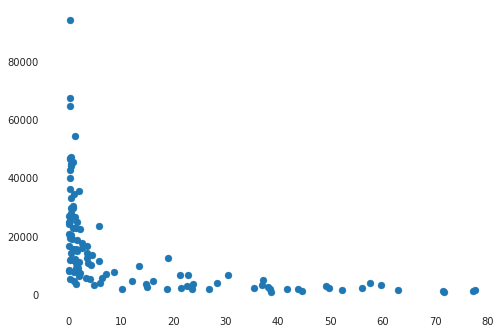

In [11]:
column = 'extreme_poverty'
extreme_poverty = data.groupby('location')[column].max().dropna() # select only countries that have valid extreme poverty values
gdp_per_capita = data.groupby('location')['gdp_per_capita'].max().loc[nas_perc[nas_perc[column] != 100].index.values] # selects only gdp of countries that have the extreme poverty feature collected
corr = extreme_poverty.corr(gdp_per_capita)
fig1 = plt.scatter(extreme_poverty, gdp_per_capita)
print('Correlation between GDP per capita and {} is: {}.'.format(column, corr))


Correlation between GDP per capita and handwashing_facilities is: 0.6888388367821999.


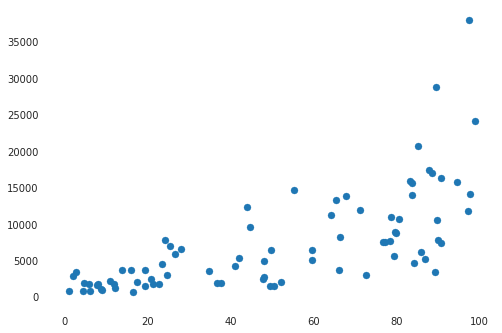

In [12]:
column = 'handwashing_facilities'
extreme_poverty = data.groupby('location')[column].max().dropna() # select only countries that have valid extreme poverty values
gdp_per_capita = data.groupby('location')['gdp_per_capita'].max().loc[nas_perc[nas_perc[column] != 100].index.values] # selects only gdp of countries that have the extreme poverty feature collected
corr = extreme_poverty.corr(gdp_per_capita)
fig1 = plt.scatter(extreme_poverty, gdp_per_capita)
print('Correlation between GDP per capita and {} is: {}.'.format(column, corr))

Correlation between GDP per capita and hospital_beds_per_thousand is: 0.29524217315857276.


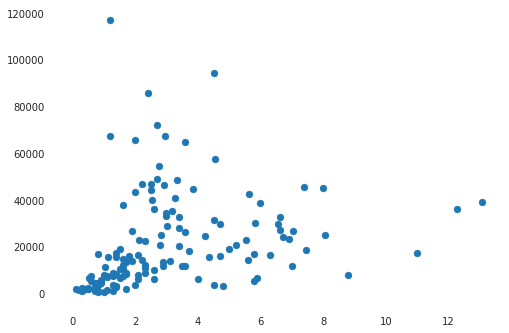

In [13]:
column = 'hospital_beds_per_thousand'
extreme_poverty = data.groupby('location')[column].max().dropna() # select only countries that have valid extreme poverty values
gdp_per_capita = data.groupby('location')['gdp_per_capita'].max().loc[nas_perc[nas_perc[column] != 100].index.values] # selects only gdp of countries that have the extreme poverty feature collected
corr = extreme_poverty.corr(gdp_per_capita)
fig1 = plt.scatter(extreme_poverty, gdp_per_capita)
print('Correlation between GDP per capita and {} is: {}.'.format(column, corr))

# Results
We can see from the results above that both "*extreme poverty*" and "*handwashing facilities*" are highly correlated with "*GDP per capita*"; however, "*Hospital beds per thousand*" is not. Unfortunately, we will have to drop this feature anyway, since there are multiple countries missing this information.

# Removal of Features
Removal of features analyzed above, as well as both female and male smokers, due to lack of data.


In [14]:
columns_to_drop = []
columns_to_drop.extend(['extreme_poverty', 'handwashing_facilities']) # removed for lacked of data in many countries and high correlation with gdp_per_capita
columns_to_drop.extend(['female_smokers', 'male_smokers'])   # removed for lack of data in many countries
columns_to_drop.extend(['hospital_beds_per_thousand']) # removed for lack of data in many countries
data.drop(columns=columns_to_drop, inplace=True)

# updates na's dataframes
total_nas_df, nas_perc = na_dfs(data)

# Smoothing *new_cases_per_million*
The "*new_cases_per_million*" feature is highly noisy. A new column "*new_cases_per_million_smoothed"* will be created by averaging the values from the last 5 days for each country.

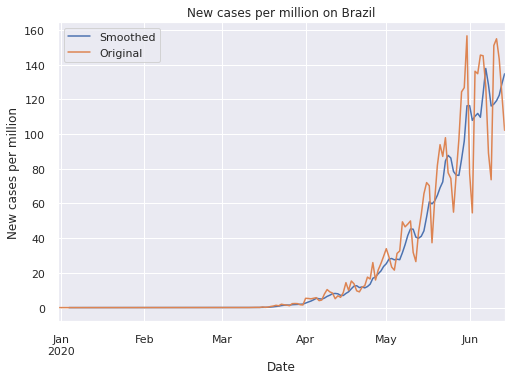

In [15]:
data['new_cases_per_million_smoothed'] = data.groupby('location')['new_cases_per_million'].rolling(window=5).mean().droplevel(0)    # creates new new_cases_per_million_smoothed feature. Since rolling for some reason duplicates 'location' index when used with groupby, it must be dropped

# plot comparsion between the original feature and the smoothed version of it
sns.set(style='darkgrid')
country = 'Brazil'
data.loc[country]['new_cases_per_million_smoothed'].plot(label='Smoothed')
data.loc[country]['new_cases_per_million'].plot(label='Original')
plt.title('New cases per million on {}'.format(country))
plt.xlabel('Date')
plt.ylabel('New cases per million')
plt.legend()


# Creating "*susceptibles_per_million*" column
The *susceptibles_per_million* feature is created by subtracting the *total_cases_per_million* feature from the total number of people per one million people (that is, of course, always one million).

Text(0.5, 1.0, 'Susceptibles per million on Brazil')

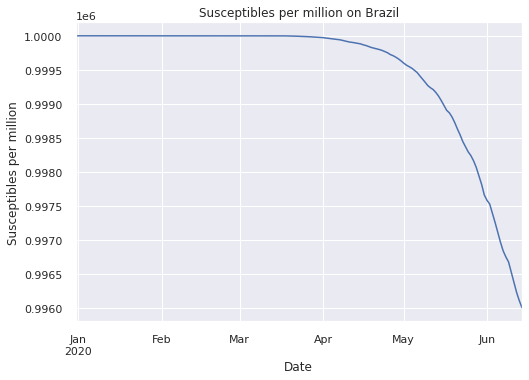

In [16]:
data['susceptibles_per_million'] = 1e6 - data['total_cases_per_million']    # creates new feature
country = 'Brazil'
data.loc[country]['susceptibles_per_million'].plot(label='Susceptibles per million')
plt.xlabel('Date')
plt.ylabel('Susceptibles per million')
plt.title('Susceptibles per million on {}'.format(country))


# Creating "*infection_rate*" feature
The *infection_rate* is calculated by using a simplification of the formula $\displaystyle \frac{dI}{dt} =  \beta I S - \gamma I$, used by the [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) to describe infection behavior:

- $\beta$ =  *Infection rate*
- $I$ = *People infected*
- $S$ = *People susceptible to infection*
- $\gamma$ = *Recovery rate*

In this simplification, $ - \gamma I $ is not taken into account, since we do not have data from recovered people, and are considering *Infected* to be the people currently infected as well as previous infected people who recovered (the data doesn't seem to regard recovery to account for the total number of cases, so we can consider the *total_cases* feature to be people who, in some point of time, have been infected). Using this simplification, we end up with $\displaystyle \frac{dI}{dt} =  \beta I S$:

- $\displaystyle \frac{dI}{dt}$ = *new_cases_per_million_smoothed*, on day $t$.
- $\beta$ = *infection_rate*, the new feature which we're trying to compute.
- $I$ = *total_cases_per_million* on the day before, $t - 1$.
- $S$ = *susceptibles_per_million* on the day before, $t - 1$.

The new *infection_rate* feature, on a day $t$, will then be:
$\displaystyle infection\_rate_{t} = \frac{new\_cases\_per\_million\_smoothed_{t}}{susceptibles\_per\_million\_{t - 1} \times total\_cases\_per\_million_{t - 1}} $

Text(0.5, 1.0, 'Infection rate on Brazil')

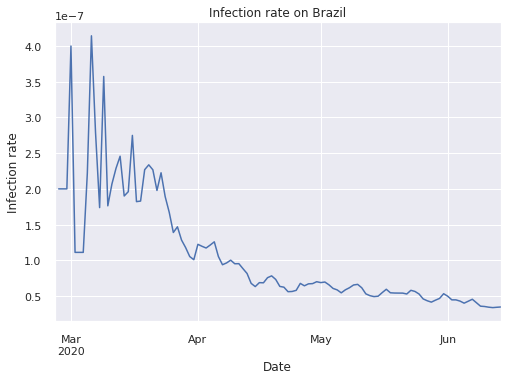

In [17]:
data['infection_rate'] = data['new_cases_per_million_smoothed'] / (data.groupby('location').shift(1)['susceptibles_per_million'] * data.groupby('location').shift(1)['total_cases_per_million'])
data['infection_rate'].where(data['days_into_pandemic'] >= 0, other=0, inplace=True)   # replaces na values generated by division by zero for the days before the pandemic has started in each country

# plots infection rate for specific country
country = 'Brazil'
data[data['days_into_pandemic'] >= 0].loc[country]['infection_rate'].plot(label='Infection rate')
plt.xlabel('Date')
plt.ylabel('Infection rate')
plt.title('Infection rate on {}'.format(country))

# Finding correlation between *infection_rate* and past *stringency_index* values
The *infection_rate* feature is likely linked to the *stringency_index* by a lag of some days (since infected people take some time to develop symptoms, stringency measures will probably have a correlation with how fast new people get infected in the future). 

Text(0.5, 1.0, 'Infection rate x Stringency index 15 days before on Italy')

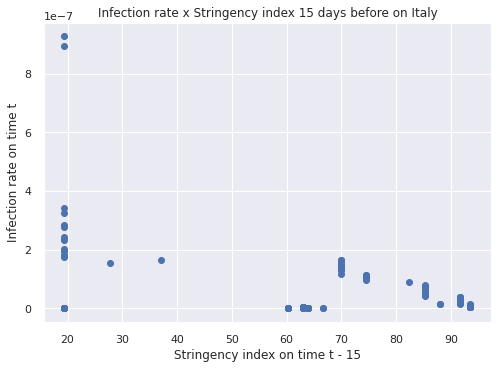

In [18]:
# plots scatter plot of observations of infection rate and the corresponding stringency index lagged by some days, for a specific country
lag_days = 15
country = 'Italy'
country_data = data.loc[country]
plt.scatter(country_data[country_data['days_into_pandemic'] >= 0]['stringency_index'].shift(lag_days), country_data[country_data['days_into_pandemic'] >= 0]['infection_rate'])
plt.xlabel('Stringency index on time t - {}'.format(lag_days))
plt.ylabel('Infection rate on time t')
plt.title('Infection rate x Stringency index {} days before on {}'.format(lag_days, country))

In [33]:
# creates a correlations list that contains the mean correlations (averaged across countries) between infection_rate and stringency_index lagged from 1 to max_lag_days
max_lag_days = 50
correlations = list()
for lag_days in range(1, max_lag_days + 1):
    data['past_stringency_index_on_{}_days'.format(lag_days)] = data.groupby('location')['stringency_index'].shift(lag_days)     # creates new temporary column to store the lagged stringency indexes
    temp = data[data['days_into_pandemic'] >= 0]    # selects only observations after the pandemic has started in each country
    temp = temp[['infection_rate', 'past_stringency_index_on_{}_days'.format(lag_days)]].groupby('location')    # selects only columns to be correlated, and groups them by country
    temp = temp.corr()  # correlation, for each country, between past stringency index and infection rate
    temp = temp['infection_rate'].drop('infection_rate', level=1).droplevel(1) # clears the correlation dataframe
    correlation = temp
    correlations.append(correlation.mean())

Text(0.5, 1.0, 'Correlation between infection rate and lagged stringency index by number of days in lag')

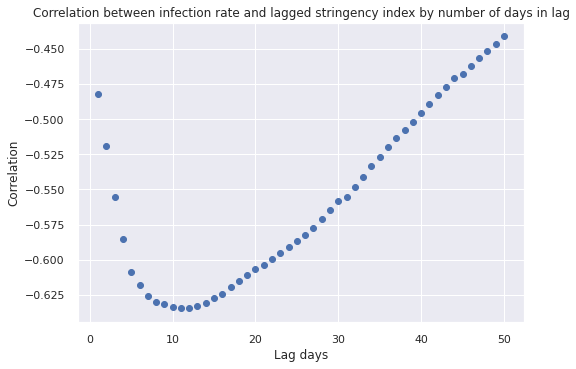

In [38]:
plt.scatter([i for i in range(1, max_lag_days + 1)], correlations)
plt.xlabel('Lag days')
plt.ylabel('Correlation')
plt.title('Correlation between infection rate and lagged stringency index by number of days in lag')


# Results
As shown by the plot above,the *infection_rate* feature has a strong negative correlation with *stringency_index*; however, this negative correlation is stronger around 11 days of time distance between the two. This suggests that stringency measures applied now will have a bigger impact on the infection rate around 11 days later.

In [45]:
correlations[11]

-0.6340855150781392

In [122]:
# Shows total missing values from each feature and total
for column in data.columns:
    na_count = data[column].isna().sum()
    print('NaN in column {}: {}.'.format(column, na_count))
print('Total NaN: {}'.format(data.isna().sum().sum()))

NaN in column iso_code: 0.
NaN in column total_cases: 0.
NaN in column new_cases: 0.
NaN in column total_deaths: 0.
NaN in column new_deaths: 0.
NaN in column total_cases_per_million: 0.
NaN in column new_cases_per_million: 0.
NaN in column total_deaths_per_million: 0.
NaN in column new_deaths_per_million: 0.
NaN in column stringency_index: 0.
NaN in column population: 0.
NaN in column population_density: 0.
NaN in column median_age: 0.
NaN in column aged_65_older: 0.
NaN in column gdp_per_capita: 0.
NaN in column cvd_death_rate: 0.
NaN in column diabetes_prevalence: 0.
NaN in column days_into_pandemic: 0.
NaN in column new_cases_per_million_smoothed: 632.
NaN in column susceptibles_per_million: 0.
NaN in column infection_rate: 4.
Total NaN: 636
